# Simple MNIST NN from scratch
In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset.

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/digit-recognizer)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("./train.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255.0

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255.0

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 128 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 128 x m
- $W^{[1]}$: 128 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 128 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[2]}$: 10 x 128 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 128
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 128 x m ($~A^{[1]}$)
- $dW^{[1]}$: 128 x 784
- $dB^{[1]}$: 128 x 1

In [5]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(10, 128) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [6]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations, batch_size=64):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]
    
    for i in range(iterations):
        # Shuffle data for mini-batch
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]
        
        # Mini-batch training
        for j in range(0, m, batch_size):
            end = min(j + batch_size, m)
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[j:end]
            batch_m = X_batch.shape[1]
            
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch, batch_m)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Print accuracy every 10 iterations on full dataset
        if i % 10 == 0:
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration: {i}, Accuracy: {accuracy:.4f}")
    
    return W1, b1, W2, b2

In [7]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration: 0, Accuracy: 0.9208
Iteration: 10, Accuracy: 0.9785
Iteration: 10, Accuracy: 0.9785
Iteration: 20, Accuracy: 0.9924
Iteration: 20, Accuracy: 0.9924
Iteration: 30, Accuracy: 0.9975
Iteration: 30, Accuracy: 0.9975
Iteration: 40, Accuracy: 0.9991
Iteration: 40, Accuracy: 0.9991
Iteration: 50, Accuracy: 0.9999
Iteration: 50, Accuracy: 0.9999
Iteration: 60, Accuracy: 1.0000
Iteration: 60, Accuracy: 1.0000
Iteration: 70, Accuracy: 1.0000
Iteration: 70, Accuracy: 1.0000
Iteration: 80, Accuracy: 1.0000
Iteration: 80, Accuracy: 1.0000
Iteration: 90, Accuracy: 1.0000
Iteration: 90, Accuracy: 1.0000
Iteration: 100, Accuracy: 1.0000
Iteration: 100, Accuracy: 1.0000
Iteration: 110, Accuracy: 1.0000
Iteration: 110, Accuracy: 1.0000
Iteration: 120, Accuracy: 1.0000
Iteration: 120, Accuracy: 1.0000
Iteration: 130, Accuracy: 1.0000
Iteration: 130, Accuracy: 1.0000
Iteration: 140, Accuracy: 1.0000
Iteration: 140, Accuracy: 1.0000
Iteration: 150, Accuracy: 1.0000
Iteration: 150, Accuracy: 1.00

In [8]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


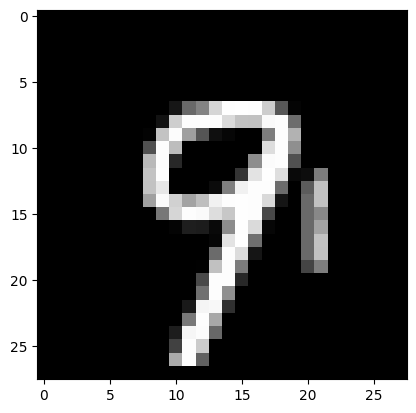

Prediction:  [5]
Label:  5


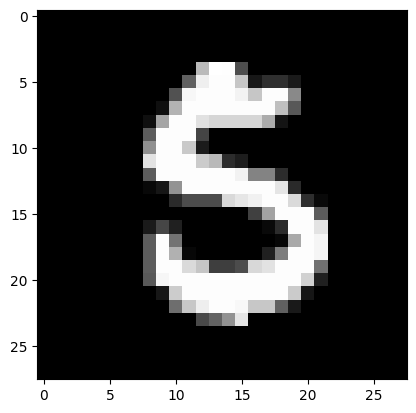

Prediction:  [3]
Label:  3


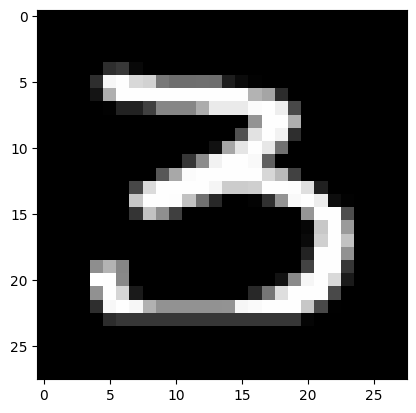

Prediction:  [2]
Label:  2


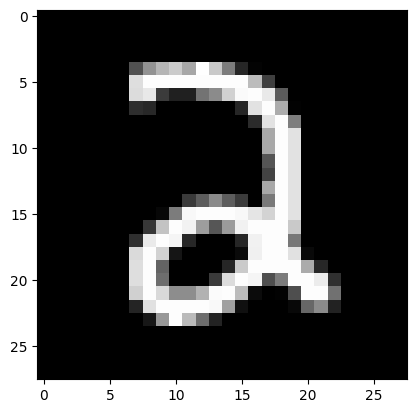

In [9]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [10]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

np.float64(0.97)